<h2><center>STAGE 1 - DATA ANALYSIS AND PROCESSING</center></h2>

---

In [1]:
import os
import numpy as np
import pandas as pd

from unidecode import unidecode

In [2]:
from utils.data_comparison import check_unique_value_equality, is_subset_of, get_set_differences

In [3]:
from utils.plots import create_count_plot, create_violin_plot

In [4]:
from utils.constants import category_mappings, plots_folder

In [5]:
from utils.constants import original_dataset_folder, customers_original_dataset, geolocation_original_dataset, items_original_dataset, \
    payments_original_dataset, reviews_original_dataset, orders_original_dataset, products_original_dataset, sellers_original_dataset, \
        category_original_dataset

In [6]:
from utils.constants import processed_dataset_folder, customers_processed_dataset, geolocation_processed_dataset, \
    items_processed_dataset, payments_processed_dataset, reviews_processed_dataset, orders_processed_dataset, \
        products_processed_dataset, sellers_processed_dataset, category_processed_dataset

<h2>1. READING THE FILES</h2>

In [7]:
customers = pd.read_csv(os.path.join(original_dataset_folder, customers_original_dataset))
geolocation = pd.read_csv(os.path.join(original_dataset_folder, geolocation_original_dataset))
items = pd.read_csv(os.path.join(original_dataset_folder, items_original_dataset))
payments = pd.read_csv(os.path.join(original_dataset_folder, payments_original_dataset))
reviews = pd.read_csv(os.path.join(original_dataset_folder, reviews_original_dataset))
orders = pd.read_csv(os.path.join(original_dataset_folder, orders_original_dataset))
products = pd.read_csv(os.path.join(original_dataset_folder, products_original_dataset))
sellers = pd.read_csv(os.path.join(original_dataset_folder, sellers_original_dataset))
category = pd.read_csv(os.path.join(original_dataset_folder, category_original_dataset))

<h2>2. IDENTIFICATION OF PROBLEMS AND ERRORS</h2>

<h3>EXPLORATORY ANALYSIS</h3>

In [8]:
datasets = [customers, geolocation, orders, payments, items, reviews, products, sellers, category]
names = ['customers', 'geolocation', 'orders', 'payments', 'items', 'reviews', 'products', 'sellers', 'category']

data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['num_rows'] = [df.shape[0] for df in datasets]
data_info['num_columns'] = [df.shape[1] for df in datasets]
data_info['num_values'] = [df.count().sum() for df in datasets]
data_info['num_missing_values'] = [df.isna().sum().sum() for df in datasets]
data_info['%_missing_values'] =  [round((df.isna().sum().sum() / df.size) * 100,2) for df in datasets]

In [9]:
data_info

,dataset,num_rows,num_columns,num_values,num_missing_values,%_missing_values
0,customers,99441,5,497205,0,0.00
1,geolocation,1000163,5,5000815,0,0.00
2,orders,99441,8,790620,4908,0.62
3,payments,103886,5,519430,0,0.00
4,items,112650,7,788550,0,0.00
5,reviews,99224,7,548665,145903,21.01
6,products,32951,9,294111,2448,0.83
7,sellers,3095,4,12380,0,0.00
8,category,71,2,142,0,0.00


In [10]:
print('The mean number of rows in the datasets is: ', round(data_info['num_rows'].mean()))
print('The mean number of columns in the datasets is: ', round(data_info['num_columns'].mean()))
print('The total number of values in the datasets is: ', data_info['num_values'].sum())
print('The total number of missing values in the datasets is: ', data_info['num_missing_values'].sum())
print('The mean percentage of missing values in the datasets is: ', round(data_info['num_missing_values'].sum()/(data_info['num_values'].sum() + data_info['num_missing_values'].sum())*100, 1),'%')

The mean number of rows in the datasets is:  172325
The mean number of columns in the datasets is:  6
The total number of values in the datasets is:  8451918
The total number of missing values in the datasets is:  153259
The mean percentage of missing values in the datasets is:  1.8 %


<h3>STANDARDIZATION OF DATA</h3>

<h4>TABLES <sup>CUSTOMERS</sup> and <sup>ORDERS</sup></h4>

In [11]:
check_unique_value_equality(customers, 'customer_id', orders, 'customer_id')

True

<h4>TABLES <sup>CUSTOMERS</sup> and <sup>GEOLOCATION</sup></h4>

In [12]:
check_unique_value_equality(customers, 'customer_zip_code_prefix', geolocation, 'geolocation_zip_code_prefix')

False

In [13]:
is_subset_of(geolocation, 'geolocation_zip_code_prefix', customers, 'customer_zip_code_prefix')

False


In [14]:
is_subset_of(customers, 'customer_zip_code_prefix', geolocation, 'geolocation_zip_code_prefix')

False


In [15]:
customers_zip_codes = set(customers["customer_zip_code_prefix"].unique())
geolocation_zip_codes = set(geolocation["geolocation_zip_code_prefix"].unique())

missing_zip_codes = customers_zip_codes - geolocation_zip_codes

new_entries = pd.DataFrame({'geolocation_zip_code_prefix': list(missing_zip_codes),
                            'geolocation_lat': [np.nan] * len(missing_zip_codes),
                            'geolocation_lng': [np.nan] * len(missing_zip_codes),
                            'geolocation_city': [np.nan] * len(missing_zip_codes),
                            'geolocation_state': [np.nan] * len(missing_zip_codes)})

new_entries['geolocation_city'] = new_entries['geolocation_city'].astype('object')
new_entries['geolocation_state'] = new_entries['geolocation_state'].astype('object')

for index, row in customers.iterrows():
    if row['customer_zip_code_prefix'] in new_entries['geolocation_zip_code_prefix'].tolist():
        new_entries.loc[new_entries['geolocation_zip_code_prefix'] == row['customer_zip_code_prefix'], 
                                    'geolocation_city'] = row['customer_city']
        new_entries.loc[new_entries['geolocation_zip_code_prefix'] == row['customer_zip_code_prefix'], 
                                    'geolocation_state'] = row['customer_state']

geolocation = pd.concat([geolocation, new_entries], ignore_index=True)

In [16]:
is_subset_of(customers, 'customer_zip_code_prefix', geolocation, 'geolocation_zip_code_prefix')

True
The percentage of correspondence is: 78.208 %


<h4>TABLES <sup>GEOLOCATION</sup> and <sup>SELLERS</sup></h4>

In [17]:
check_unique_value_equality(sellers, 'seller_zip_code_prefix', geolocation, 'geolocation_zip_code_prefix')

False

In [18]:
is_subset_of(sellers, 'seller_zip_code_prefix', geolocation, 'geolocation_zip_code_prefix')

False


In [19]:
get_set_differences(sellers, 'seller_zip_code_prefix', geolocation, 'geolocation_zip_code_prefix')

{2285, 37708, 72580, 82040, 91901}

In [20]:
sellers_zip_codes = set(sellers['seller_zip_code_prefix'].unique())
geolocation_zip_codes = set(geolocation['geolocation_zip_code_prefix'].unique())

missing_zip_codes = sellers_zip_codes - geolocation_zip_codes

new_entries = pd.DataFrame({'geolocation_zip_code_prefix': list(missing_zip_codes),
                            'geolocation_lat': [np.nan] * len(missing_zip_codes),
                            'geolocation_lng': [np.nan] * len(missing_zip_codes),
                            'geolocation_city': [np.nan] * len(missing_zip_codes),
                            'geolocation_state': [np.nan] * len(missing_zip_codes)})

new_entries['geolocation_city'] = new_entries['geolocation_city'].astype('object')
new_entries['geolocation_state'] = new_entries['geolocation_state'].astype('object')

for index, row in sellers.iterrows():
    if row['seller_zip_code_prefix'] in new_entries['geolocation_zip_code_prefix'].tolist():
        new_entries.loc[new_entries['geolocation_zip_code_prefix'] == row['seller_zip_code_prefix'], 
                                    'geolocation_city'] = row['seller_city']
        new_entries.loc[new_entries['geolocation_zip_code_prefix'] == row['seller_zip_code_prefix'], 
                                    'geolocation_state'] = row['seller_state']

geolocation = pd.concat([geolocation, new_entries], ignore_index=True)

In [21]:
is_subset_of(sellers, 'seller_zip_code_prefix', geolocation, 'geolocation_zip_code_prefix')

True
The percentage of correspondence is: 11.712 %


<h4>TABLES <sup>ORDERS</sup> and <sup>PAYMENTS</sup></h4>

In [22]:
check_unique_value_equality(orders, 'order_id', payments, 'order_id')

False

In [23]:
is_subset_of(payments, 'order_id', orders, 'order_id')

True
The percentage of correspondence is: 99.999 %


<h4>TABLES <sup>ORDERS</sup> and <sup>REVIEWS</sup></h4>

In [24]:
check_unique_value_equality(orders, 'order_id', reviews, 'order_id')

False

In [25]:
is_subset_of(reviews, 'order_id', orders, 'order_id')

True
The percentage of correspondence is: 99.228 %


<h4>TABLES <sup>ORDERS</sup> and <sup>ITEMS</sup></h4>

In [26]:
check_unique_value_equality(orders, 'order_id', items, 'order_id')

False

In [27]:
is_subset_of(items, 'order_id', orders, 'order_id')

True
The percentage of correspondence is: 99.221 %


<h4>TABLES <sup>SELLERS</sup> and <sup>ITEMS</sup></h4>

In [28]:
check_unique_value_equality(sellers, 'seller_id', items, 'seller_id')

True

<h4>TABLES <sup>ITEMS</sup> and <sup>PRODUCTS</sup></h4>

In [29]:
check_unique_value_equality(items, 'product_id', products, 'product_id')

True

<h4>TABLES <sup>PRODUCTS</sup> and <sup>CATEGORY</sup></h4>

In [30]:
check_unique_value_equality(products, 'product_category_name', category, 'product_category_name')

False

In [31]:
is_subset_of(products, 'product_category_name', category, 'product_category_name')

False


In [32]:
is_subset_of(category, 'product_category_name', products, 'product_category_name')

True
The percentage of correspondence is: 95.946 %


In [33]:
print("Categories that are in the \"products\" table and are missing in the \"category\" table:" )
print(set(products['product_category_name'].unique()) - set(category['product_category_name']))

Categories that are in the "products" table and are missing in the "category" table:
{'portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer', nan}


In [34]:
new_category_data = pd.DataFrame({'product_category_name': ['portateis_cozinha_e_preparadores_de_alimentos', 'pc_gamer', 'sem categoria'],
                                  'product_category_name_english': ['portateis_kitchen_and_food_preparators', 'pc_gamer', 'without category']})
    
category = pd.concat([category, new_category_data], ignore_index=True)

<h3>RENAMING OF VALUES</h3>

<h4>TABLE <sup>GEOLOCATION</sup></h4>

In [35]:
geolocation['geolocation_city'] = geolocation['geolocation_city'].apply(lambda x: unidecode(x).title() if isinstance(x, str) else x)

<h3>REMOVAL OF ROWS WITHOUT INFORMATION OR WITH IRRELEVANT INFORMATION</h3>

The correct way to check for repeated occurrences in the tables is to first identify the primary key of each table, that is, the variable(s) that uniquely identify each occurrence. Then, for each table, it is necessary to check there are no occurrences with the same primary key.

<h4>TABLE <sup>CUSTOMERS</sup></h4>

In [36]:
customers['customer_id'].duplicated().any()

False

<h4>TABLE <sup>GEOLOCATION</sup></h4>

In [37]:
grouped = geolocation.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat': 'mean', 
                                                                  'geolocation_lng': 'mean'}).reset_index()

for zip_code in geolocation['geolocation_zip_code_prefix'].unique():
    is_matching_zip_code = geolocation['geolocation_zip_code_prefix'] == zip_code
    geolocation.loc[is_matching_zip_code, 'geolocation_lat'] = grouped.loc[grouped['geolocation_zip_code_prefix'] == zip_code, 
                                                                           'geolocation_lat'].iloc[0]
    geolocation.loc[is_matching_zip_code, 'geolocation_lng'] = grouped.loc[grouped['geolocation_zip_code_prefix'] == zip_code, 
                                                                           'geolocation_lng'].iloc[0]

In [38]:
geolocation.drop_duplicates(subset=['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng'], inplace=True)

In [39]:
print('Are there duplicated zip code values in the geolocation table?', )
geolocation.duplicated(subset=['geolocation_zip_code_prefix']).sum()

Are there duplicated zip code values in the geolocation table?


0

<h4>TABLE <sup>ORDERS</sup></h4>

In [40]:
orders['order_id'].duplicated().any()

False

<h4>TABLE <sup>SELLERS</sup></h4>

In [41]:
sellers['seller_id'].duplicated().any()

False

<h4>TABLE <sup>ITEMS</sup></h4>

In [42]:
items[['order_id','order_item_id','product_id','seller_id']].duplicated().any()

False

<h4>TABLE <sup>PRODUCTS</sup></h4>

In [43]:
products['product_id'].duplicated().any()

False

<h4>TABLE <sup>PAYMENTS</sup></h4>

In [44]:
payments[['order_id', 'payment_sequential']].duplicated().any()

False

<h4>TABLE <sup>REVIEWS</sup></h4>

In [45]:
reviews[['review_id', 'order_id']].duplicated().any()

False

<h4>TABLE <sup>CATEGORY</sup></h4>

In [46]:
category['product_category_name_english'].duplicated().any()

False

<h3>REMOVAL OF IRRELEVANT COLUMNS AND RENAMING OF COLUMNS</h3>

<h4>TABLE <sup>CUSTOMERS</sup></h4>

In [47]:
customers.drop(columns=['customer_city', 'customer_state'], inplace=True)

<h4>TABLE <sup>GEOLOCATION</sup></h4>

In [48]:
geolocation = geolocation.rename(columns={'geolocation_zip_code_prefix': 'zip_code_prefix', 
                                          'geolocation_lat': 'latitude', 
                                          'geolocation_lng': 'longitude', 
                                          'geolocation_city': 'city', 
                                          'geolocation_state': 'state'})                                    

<h4>TABLE <sup>SELLERS</sup></h4>

In [49]:
sellers.drop(columns=['seller_city', 'seller_state'], inplace=True)

<h4>TABLE <sup>PRODUCTS</sup></h4>

In [50]:
products.drop(columns=['product_name_lenght', 'product_description_lenght'], inplace=True)

<h4>TABLE <sup>REVIEWS</sup></h4>

In [51]:
reviews.drop(columns = ['review_comment_title', 'review_comment_message'], inplace=True)

<h3>SUBSTITUTION OF MISSING VALUES</h3>

<h4>TABLE <sup>CUSTOMERS</sup></h4>

In [52]:
print(f'The customers table has {customers.isna().sum().sum()} missing values.')

The customers table has 0 missing values.


<h4>TABLE <sup>GEOLOCATION</sup></h4>

In [53]:
print(f'The geolocation table has {geolocation.isna().sum().sum()} missing values.')

The geolocation table has 324 missing values.


In [54]:
mean_coordinates_by_city = geolocation.groupby('city').agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()

replace_nan_coordinate_values = lambda x: x.fillna(
    mean_coordinates_by_city[mean_coordinates_by_city['city'] == x['city']].squeeze()[1:]) if np.isnan(x['latitude']) \
                                                                                           or np.isnan(x['longitude']) \
                                                                                           else x

geolocation = geolocation.apply(replace_nan_coordinate_values, axis=1)

In [55]:
print(f'The geolocation table has {geolocation.isna().sum().sum()} missing values.')

The geolocation table has 84 missing values.


In [56]:
mean_coordinates_by_state = geolocation.groupby('state').agg({'latitude': 'mean', 'longitude': 'mean'}).reset_index()

replace_nan_coordinate_values = lambda row: row.fillna(
    mean_coordinates_by_state[mean_coordinates_by_state['state'] == row['state']].squeeze()[1:]) if np.isnan(row['latitude']) \
                                                                                                 or np.isnan(row['longitude']) \
                                                                                                 else row

geolocation = geolocation.apply(replace_nan_coordinate_values, axis=1)

In [57]:
print(f'The geolocation table has {geolocation.isna().sum().sum()} missing values.')

The geolocation table has 0 missing values.


<h4>TABLE <sup>ORDERS</sup></h4>

In [58]:
print(f'The orders table has {orders.isna().sum().sum()} missing values.')
print('The percentage of missing values in the orders table is: {:.1f} %'.format((orders.isna(
                                                                                ).sum().sum()/orders.count().sum()) * 100))
print('The percentage of missing values per entry in the orders table is: {:.1f} %'.format((orders.isna(
                                                                                ).sum().sum()/orders.shape[0] * 100)))

The orders table has 4908 missing values.
The percentage of missing values in the orders table is: 0.6 %
The percentage of missing values per entry in the orders table is: 4.9 %


In [59]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [60]:
removed_order_id_entries = pd.DataFrame(columns=['order_id'])
removed_order_id_entries['order_id'] = orders['order_id'][orders['order_approved_at'].isna() 
                                                          | orders['order_delivered_carrier_date'].isna()
                                                          | orders['order_delivered_customer_date'].isna()]

In [61]:
orders.dropna(subset=['order_approved_at', 'order_delivered_carrier_date', 
                      'order_delivered_customer_date'], axis=0, inplace = True)

In [62]:
print(f'The orders table has {orders.isna().sum().sum()} missing values after data processing.')

The orders table has 0 missing values after data processing.


<h4>TABLE <sup>SELLERS</sup></h4>

In [63]:
print(f'The sellers table has {sellers.isna().sum().sum()} null values.')

The sellers table has 0 null values.


<h4>TABLE <sup>ITEMS</sup></h4>

In [64]:
print(f'The items table has {items.isna().sum().sum()} null values.')

The items table has 0 null values.


In [65]:
items = items[~items['order_id'].isin(removed_order_id_entries['order_id'])]

In [66]:
is_subset_of(items, 'order_id', orders, 'order_id')

True
The percentage of correspondence is: 100.0 %


<h4>TABLE <sup>PRODUCTS</sup></h4>

In [67]:
print(f'The products table has {products.isna().sum().sum()} missing values.')

The products table has 1228 missing values.


In [68]:
products.isna().sum()

product_id                 0
product_category_name    610
product_photos_qty       610
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
dtype: int64

In [69]:
products['product_category_name'] = products['product_category_name'].fillna('sem categoria')
products.fillna(value={'product_photos_qty': 0, 
                       'product_weight_g': 0, 
                       'product_length_cm': 0, 
                       'product_height_cm': 0, 
                       'product_width_cm': 0}, inplace=True)

In [70]:
print(f'The products table has {products.isna().sum().sum()} missing values.')

The products table has 0 missing values.


<h4>TABLE <sup>PAYMENTS</sup></h4>

In [71]:
print(f'The payments table has {payments.isna().sum().sum()} missing values.')

The payments table has 0 missing values.


In [72]:
payments = payments[~payments['order_id'].isin(removed_order_id_entries['order_id'])]

<h4>TABLE <sup>REVIEWS</sup></h4>

In [73]:
print(f'The reviews table has {reviews.isna().sum().sum()} missing values.')

The reviews table has 0 missing values.


In [74]:
reviews = reviews[~reviews['order_id'].isin(removed_order_id_entries['order_id'])]

<h3>ADDITION OF NEW COLUMNS</h3>

<h4>TABLE <sup>CATEGORY</sup></h4>

In [75]:
category['product_main_category_name']= category['product_category_name'].map(category_mappings)

In [76]:
print("The main categories of products are:", ', '.join(category['product_main_category_name'].unique()))

The main categories of products are: Health and Beauty, Technology and Home Appliances, Others, Home and Decor, Sports and Leisure, Fashion, Food, Children, Stationery and Books, Materials and Construction, Animals, Market Place, Services and Commerce, Music and Art, Without Category


In [77]:
category.head()

,product_category_name,product_category_name_english,product_main_category_name
0,beleza_saude,health_beauty,Health and Beauty
1,informatica_acessorios,computers_accessories,Technology and Home Appliances
2,automotivo,auto,Others
3,cama_mesa_banho,bed_bath_table,Home and Decor
4,moveis_decoracao,furniture_decor,Home and Decor


<h2>3. Analysis of the Data</h2>

<h4>TABLE <sup>CUSTOMERS</sup></h4>

In [78]:
customers.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 17.6 MB


<h4>TABLE <sup>GEOLOCATION</sup></h4>

In [79]:
geolocation.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 19177 entries, 0 to 1000324
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   zip_code_prefix  19177 non-null  int64  
 1   latitude         19177 non-null  float64
 2   longitude        19177 non-null  float64
 3   city             19177 non-null  object 
 4   state            19177 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 2.9 MB


<h4>TABLE <sup>ORDERS</sup></h4>

In [80]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 96461 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       96461 non-null  object
 1   customer_id                    96461 non-null  object
 2   order_status                   96461 non-null  object
 3   order_purchase_timestamp       96461 non-null  object
 4   order_approved_at              96461 non-null  object
 5   order_delivered_carrier_date   96461 non-null  object
 6   order_delivered_customer_date  96461 non-null  object
 7   order_estimated_delivery_date  96461 non-null  object
dtypes: object(8)
memory usage: 58.1 MB


<h4>TABLE <sup>ITEMS</sup></h4>

In [81]:
items.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 110180 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             110180 non-null  object 
 1   order_item_id        110180 non-null  int64  
 2   product_id           110180 non-null  object 
 3   seller_id            110180 non-null  object 
 4   shipping_limit_date  110180 non-null  object 
 5   price                110180 non-null  float64
 6   freight_value        110180 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 39.4 MB


<h4>TABLE <sup>PRODUCTS</sup></h4>

In [82]:
products['product_photos_qty'] = products['product_photos_qty'].astype(int)
products['product_weight_g'] = products['product_weight_g'].astype(int)
products['product_length_cm'] = products['product_length_cm'].astype(int)
products['product_height_cm'] = products['product_height_cm'].astype(int)
products['product_width_cm'] = products['product_width_cm'].astype(int)

In [83]:
products.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   product_id             32951 non-null  object
 1   product_category_name  32951 non-null  object
 2   product_photos_qty     32951 non-null  int32 
 3   product_weight_g       32951 non-null  int32 
 4   product_length_cm      32951 non-null  int32 
 5   product_height_cm      32951 non-null  int32 
 6   product_width_cm       32951 non-null  int32 
dtypes: int32(5), object(2)
memory usage: 5.7 MB


<h4>TABLE <sup>SELLERS</sup></h4>

In [84]:
sellers.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 293.3 KB


<h4>TABLE <sup>PAYMENTS</sup></h4>

In [85]:
payments.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 100739 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              100739 non-null  object 
 1   payment_sequential    100739 non-null  int64  
 2   payment_type          100739 non-null  object 
 3   payment_installments  100739 non-null  int64  
 4   payment_value         100739 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 18.0 MB


<h4>TABLE <sup>REVIEWS</sup></h4>

In [86]:
reviews.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 96344 entries, 0 to 99223
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                96344 non-null  object
 1   order_id                 96344 non-null  object
 2   review_score             96344 non-null  int64 
 3   review_creation_date     96344 non-null  object
 4   review_answer_timestamp  96344 non-null  object
dtypes: int64(1), object(4)
memory usage: 31.8 MB


<h4>TABLE <sup>CATEGORY</sup></h4>

In [87]:
category.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          74 non-null     object
 1   product_category_name_english  74 non-null     object
 2   product_main_category_name     74 non-null     object
dtypes: object(3)
memory usage: 16.2 KB


<h2>3. Export of the Processed CSV Files</h2>

In [88]:
os.makedirs(processed_dataset_folder, exist_ok=True)

In [89]:
customers.to_csv(os.path.join(processed_dataset_folder, customers_processed_dataset), index=False)
geolocation.to_csv(os.path.join(processed_dataset_folder, geolocation_processed_dataset), index=False)
items.to_csv(os.path.join(processed_dataset_folder, items_processed_dataset), index=False)
payments.to_csv(os.path.join(processed_dataset_folder, payments_processed_dataset), index=False)
reviews.to_csv(os.path.join(processed_dataset_folder, reviews_processed_dataset), index=False)
orders.to_csv(os.path.join(processed_dataset_folder, orders_processed_dataset), index=False)
products.to_csv(os.path.join(processed_dataset_folder, products_processed_dataset), index=False)
sellers.to_csv(os.path.join(processed_dataset_folder, sellers_processed_dataset), index=False)
category.to_csv(os.path.join(processed_dataset_folder, category_processed_dataset), index=False)

<h2>4. Data Visualization in Python</h2>

<h4>TABLES <sup>PRODUCTS</sup> and <sup>CATEGORY</sup></h4>

In [90]:
merged_product_category = pd.merge(products, category[['product_category_name', 'product_main_category_name']], 
                                   on='product_category_name', how='left')

cols = list(products.columns)
cols.insert(2, 'product_main_category_name')
merged_product_category = merged_product_category.reindex(columns=cols)

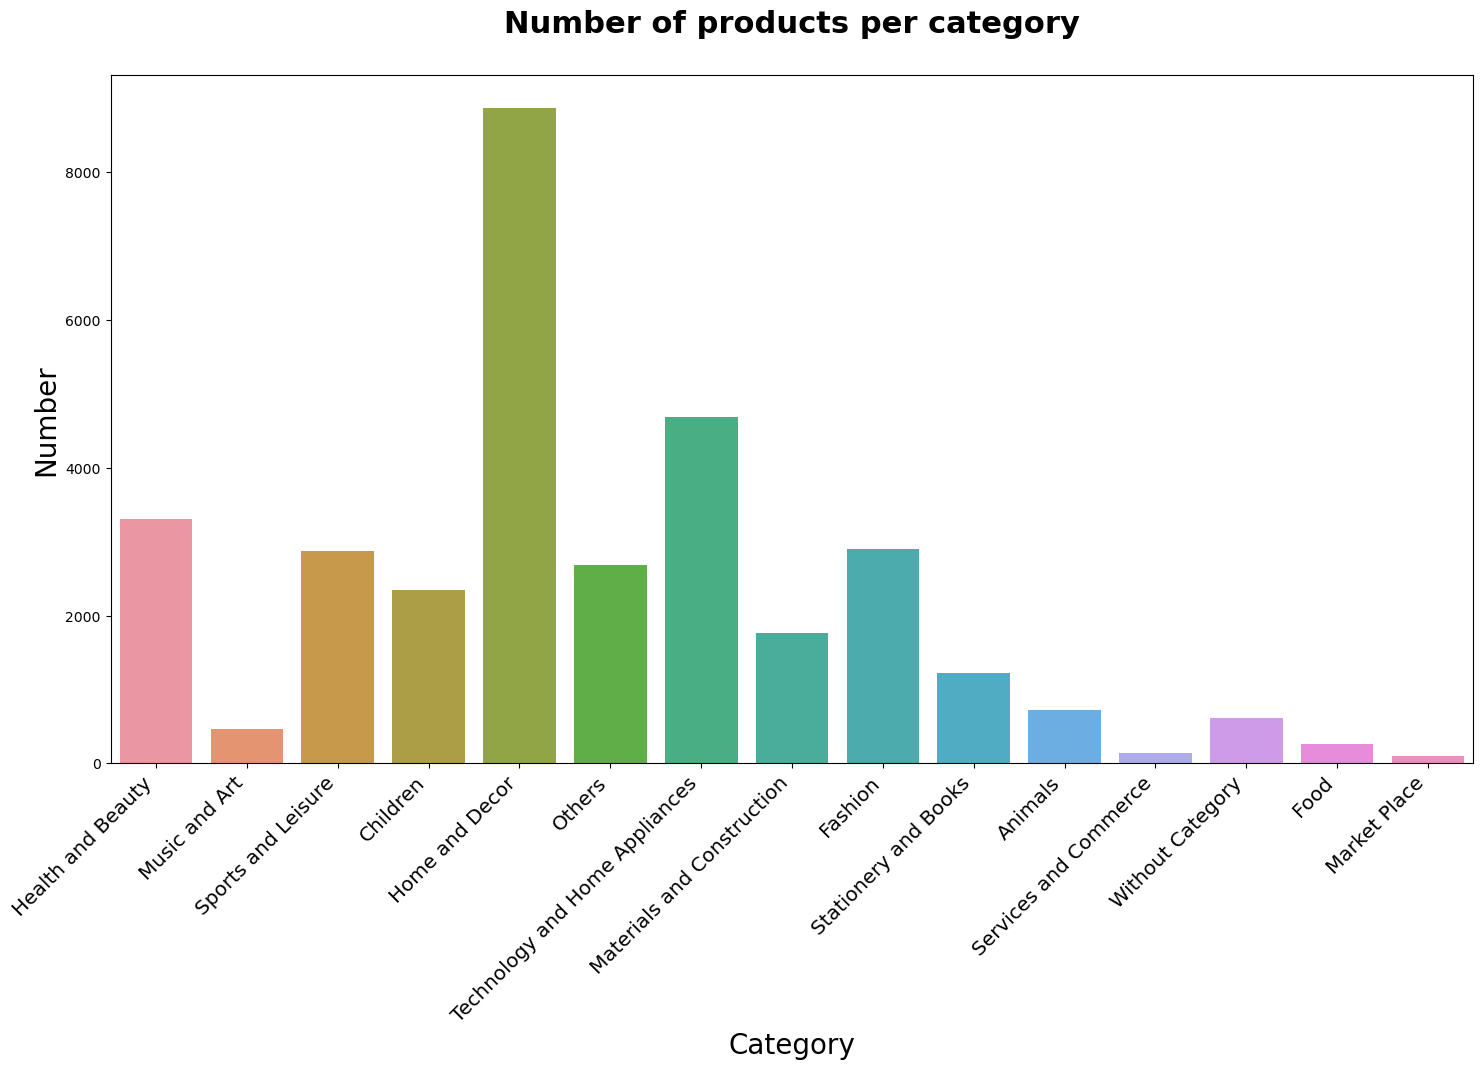

In [91]:
create_count_plot(merged_product_category, "product_main_category_name" , ["Category", "Number"], (15, 10), \
                  "Number of products per category", True, plots_folder, 'number_produts_per_category')

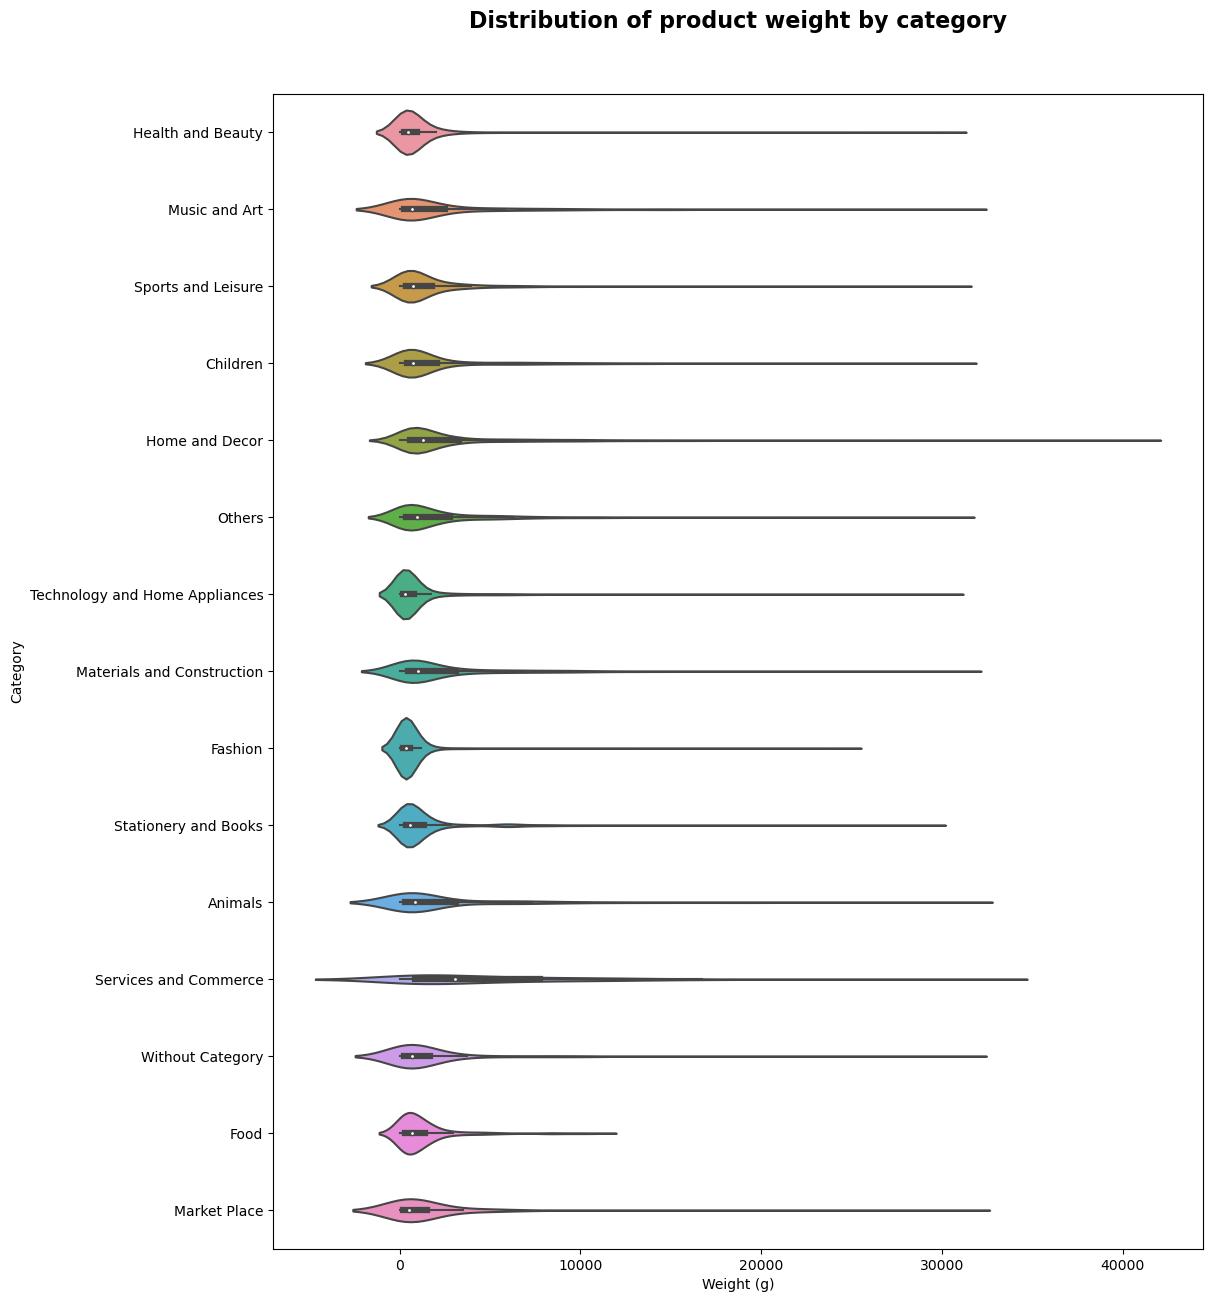

In [92]:
create_violin_plot(merged_product_category, ["product_weight_g", "product_main_category_name"], ["Weight (g)", "Category"], (12, 15), \
                   "Distribution of product weight by category", True, plots_folder, "product_weight_by_category")

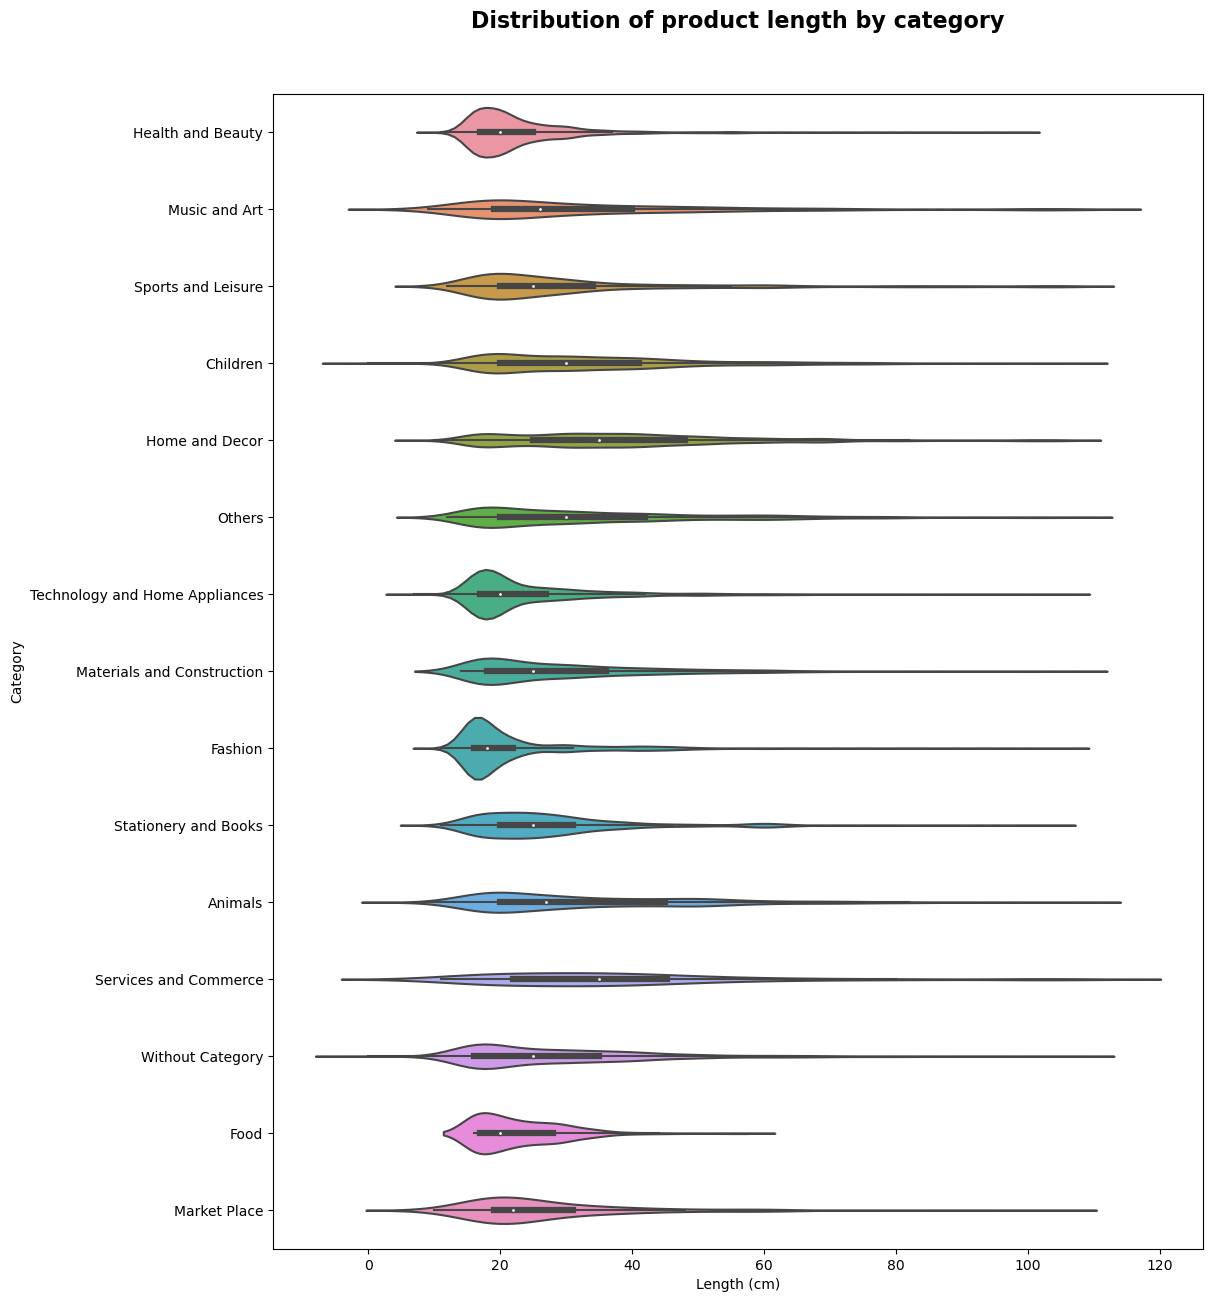

In [93]:
create_violin_plot(merged_product_category, ["product_length_cm", "product_main_category_name"], ["Length (cm)", "Category"], (12, 15), \
                   "Distribution of product length by category", True, plots_folder, "product_length_by_category")

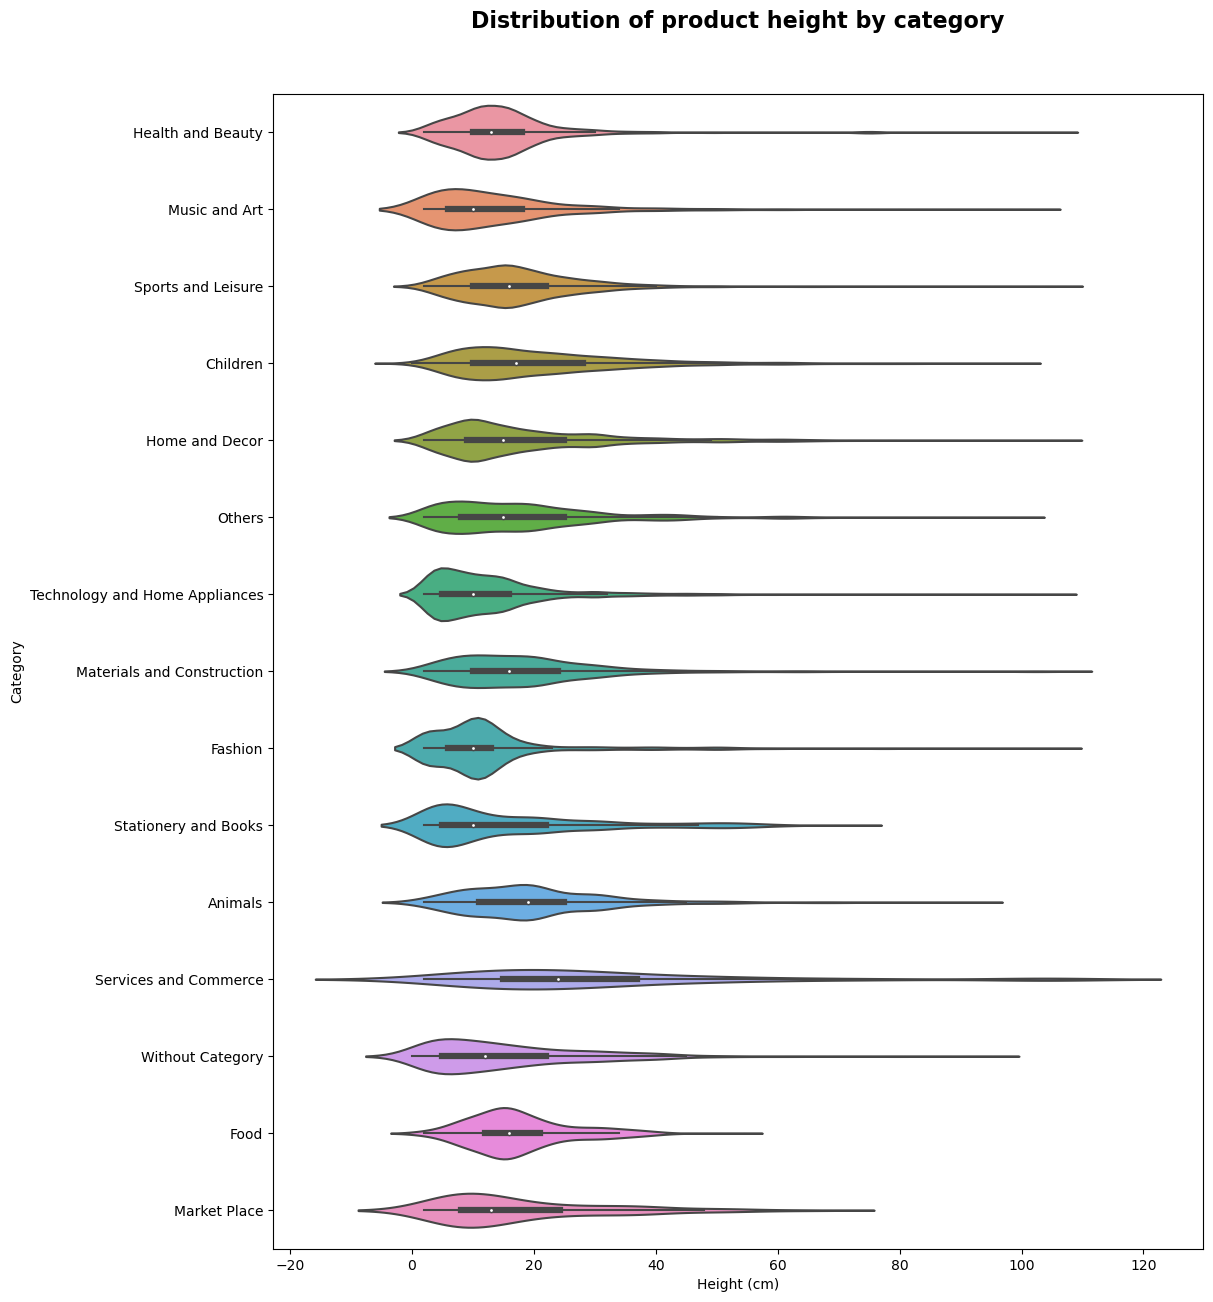

In [94]:
create_violin_plot(merged_product_category, ["product_height_cm", "product_main_category_name"], ["Height (cm)", "Category"], (12, 15), \
                   "Distribution of product height by category", True, plots_folder, "product_height_by_category")

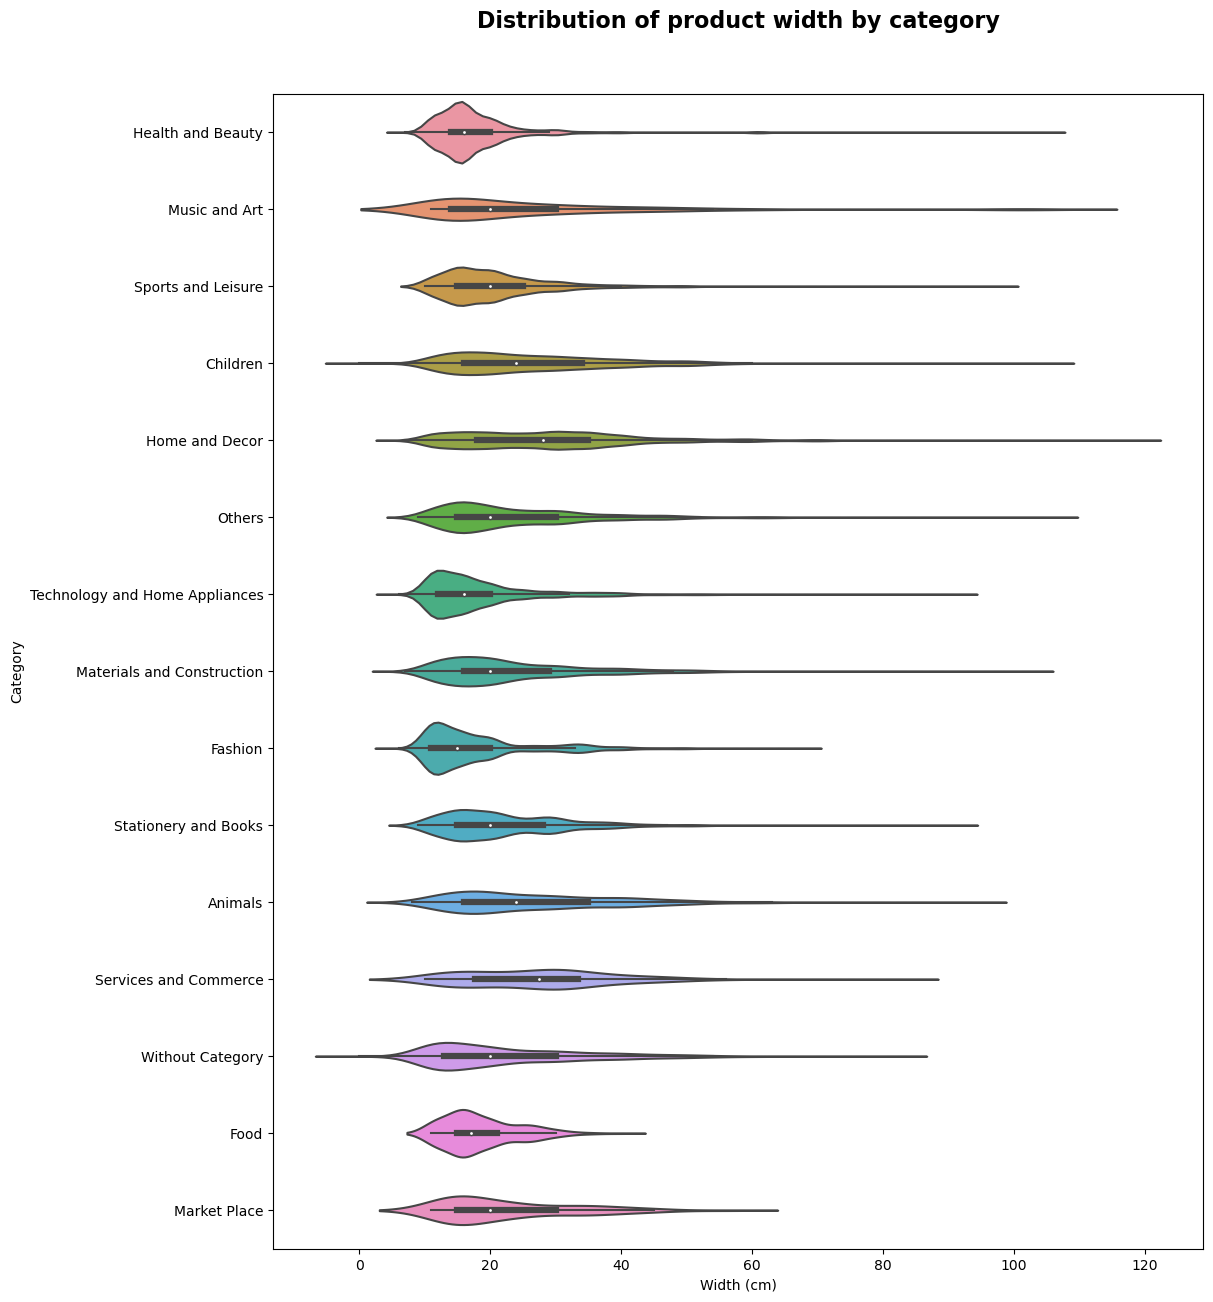

In [95]:
create_violin_plot(merged_product_category, ["product_width_cm", "product_main_category_name"], ["Width (cm)", "Category"], (12, 15), \
                   "Distribution of product width by category", True, plots_folder, "product_width_by_category")